# Test

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
from random import shuffle
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

Load the article metadata

In [3]:
def load_df(name):
    # make sure the authors_parsed column contains arrays of str, 1 str per author name
    # e.g. ['Bognár, Zs., ', 'Sódor, Á., ', 'Clark, I. R., ', 'Kawaler, S. D., ']
    return pd.read_csv(
        os.path.join(DATA_PATH, name), 
        index_col=0, 
        converters={"authors_parsed": lambda x:[entry.replace('\'', '').strip("[]") for entry in x.split("', '")]}
    )

train_df = load_df('arxiv_train.csv')
validate_df = load_df('arxiv_validate.csv')
test_df = load_df('arxiv_test.csv')

Load the article topics

In [4]:
with open(os.path.join(DATA_PATH, 'train_topic_distr_BERT_scikit.pickle'), 'rb') as handle:
    train_topic_distr = pickle.load(handle)
with open(os.path.join(DATA_PATH, 'validate_topic_distr_BERT_scikit.pickle'), 'rb') as handle:
    validate_topic_distr = pickle.load(handle)
with open(os.path.join(DATA_PATH, 'test_topic_distr_BERT_scikit.pickle'), 'rb') as handle:
    test_topic_distr = pickle.load(handle)

Merge metadata and topics into a data frame

In [5]:
def merge_df(article_df, topics_np):
    """
    Add topic distributions to article metadata.
    
    article_df: pandas.DataFrame article metadata
    topics_np: numpy.array topics distributions
    return pandas.DataFrame
    """
    topics_df = pd.DataFrame(topics_np)
    topics_df.columns = ["topic_%d"%n for n in range(len(topics_df.columns))]
    merged = article_df.reset_index(drop=True).join(topics_df.reset_index(drop=True))
    return merged

In [6]:
train_df = merge_df(train_df, train_topic_distr)
validate_df = merge_df(validate_df, validate_topic_distr)
test_df = merge_df(test_df, test_topic_distr)

## Article distances

In [7]:
import numpy as np

def topic_distance(article1, article2):
    """
    Compute the distance between 2 articles.
    article1, article2: pandas.Dataframe
    return float
    """
    # numpy array with topics probabilities for the article
    mask1 = article1.columns.str.contains("topic_.")
    topics1 = np.array(article1.loc[:, mask1])
    mask2 = article2.columns.str.contains("topic_.")
    topics2 = np.array(article2.loc[:, mask2])
    
    dist = np.linalg.norm(topics1 - topics2)  # euclidean distance, L2 norm is default
    return dist

### Tests

#### Test1
The distance between same articles should be 0

In [8]:
# pick a random paper
rnd_article = validate_df.sample()
assert topic_distance(rnd_article, rnd_article) == 0, "Distance between same articles should be 0"

#### Test2
The distance between different articles should be a non-zero positive number

In [9]:
while True:
    rnd_article1 = validate_df.sample()
    rnd_article2 = validate_df.sample()
    if rnd_article1.id.values[0] != rnd_article2.id.values[0]: break

assert topic_distance(rnd_article1, rnd_article2) > 0, "Distance between different articles should be greater than 0"

#### Test3
The distance between articles by the same author(s) should be on average smaller than that between articles by different authors (that is the essential assumption of the experiment). Fisrt test on the validation dataset.

In [10]:
def article_with_common_author(article, df):
    """
    Get a different article with at least one common author in the dataset df.
    article: pandas.DataFrame 
    df: pandas.DataFrame 
    returns: id of an article
    """
    article_found = None
    for author in article.authors_parsed.iloc[0]:
        for i,row in df.iterrows():
            if (author in row.authors_parsed) and (article.id.iloc[0]!=row.id):
                article_found = row.id
                break
    return article_found

def article_without_common_author(article, df):
    """
    Get a different article with at no common author in the dataset df.
    article: pandas.DataFrame 
    df: pandas.DataFrame 
    returns: id of an article
    """
    article_found = None
    idx = df.index.to_list()
    shuffle(idx)
    for id in idx:
        row = df.iloc[id]
        # same article
        if article.id.iloc[0] == id: 
            continue
        # common author
        for author in article.authors_parsed.iloc[0]:
            if author in row.authors_parsed: 
                continue
        article_found = row.id
        break
    return article_found

In [12]:
%%time

# pairs of article ids with at least one common author 
common_author = []
# pairs of article ids with no author in common 
no_common_author = []

# max number of articles in lists above. Note that common author might not have the max number of entries.
MAX_ARTICLES = 1000

counter = 0
while(counter < MAX_ARTICLES):
    if counter % 100 == 0: print(f"processing article {counter+1}/{MAX_ARTICLES}")
    rnd_article = validate_df.sample()
    rnd_article_common_id = article_with_common_author(rnd_article, validate_df)
    if rnd_article_common_id:
        common_author.append((rnd_article.id.iloc[0], rnd_article_common_id))
    rnd_article_no_common_id = article_without_common_author(rnd_article, validate_df)
    no_common_author.append((rnd_article.id.iloc[0], rnd_article_no_common_id))
    counter += 1

processing article 1/1000
processing article 101/1000
processing article 201/1000
processing article 301/1000
processing article 401/1000
processing article 501/1000
processing article 601/1000
processing article 701/1000
processing article 801/1000
processing article 901/1000
CPU times: user 37min 37s, sys: 5min 16s, total: 42min 53s
Wall time: 42min 54s


Calculate distances between pairs of articles with common authors, compare to distances between articles without common authors.

In [13]:
common_author_distances = []

for pair in common_author:
    article1 = validate_df[validate_df.id==pair[0]]
    article2 = validate_df[validate_df.id==pair[1]]
    distance = topic_distance(article1, article2)
    common_author_distances.append(distance)

In [14]:
no_common_author_distances = []

for pair in no_common_author:
    article1 = validate_df[validate_df.id==pair[0]]
    article2 = validate_df[validate_df.id==pair[1]]
    distance = topic_distance(article1, article2)
    no_common_author_distances.append(distance)

In [15]:
assert \
    statistics.mean(common_author_distances) < statistics.mean(no_common_author_distances), \
    "Articles with no common author are closer than articles with a common author."

#### Test4
The distance between articles by the same author(s) should be on average smaller than that between articles by different authors (that is the essential assumption of the experiment). Second test with random articles on the  validation dataset and authors on the training dataset.

In [17]:
%%time

# pairs of article ids with at least one common author 
common_author = []
# pairs of article ids with no author in common 
no_common_author = []

# max number of articles in lists above. Note that common author might not have the max number of entries.
MAX_ARTICLES = 1000

counter = 0
while(counter < MAX_ARTICLES):
    if counter % 100 == 0: print(f"processing article {counter+1}/{MAX_ARTICLES}")
    rnd_article = validate_df.sample()
    rnd_article_common_id = article_with_common_author(rnd_article, train_df)
    if rnd_article_common_id:
        common_author.append((rnd_article.id.iloc[0], rnd_article_common_id))
    rnd_article_no_common_id = article_without_common_author(rnd_article, train_df)
    no_common_author.append((rnd_article.id.iloc[0], rnd_article_no_common_id))
    counter += 1

processing article 1/1000
processing article 101/1000
processing article 201/1000
processing article 301/1000
processing article 401/1000
processing article 501/1000
processing article 601/1000
processing article 701/1000
processing article 801/1000
processing article 901/1000
CPU times: user 1h 16min 37s, sys: 15min 43s, total: 1h 32min 21s
Wall time: 1h 32min 22s


In [20]:
# save test data
with open(os.path.join(DATA_PATH, 'common_author.pickle'), 'wb') as handle:
    pickle.dump(common_author, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(DATA_PATH, 'no_common_author.pickle'), 'wb') as handle:
    pickle.dump(no_common_author, handle, protocol=pickle.HIGHEST_PROTOCOL)

Calculate distances between pairs of articles with common authors, compare to distances between articles without common authors.

In [22]:
common_author_distances = []

for pair in common_author:
    article1 = validate_df[validate_df.id==pair[0]]
    article2 = train_df[train_df.id==pair[1]]
    distance = topic_distance(article1, article2)
    common_author_distances.append(distance)

In [23]:
no_common_author_distances = []

for pair in no_common_author:
    article1 = validate_df[validate_df.id==pair[0]]
    article2 = train_df[train_df.id==pair[1]]
    distance = topic_distance(article1, article2)
    no_common_author_distances.append(distance)

In [24]:
assert \
    statistics.mean(common_author_distances) < statistics.mean(no_common_author_distances), \
    "Articles with no common author are closer than articles with a common author."

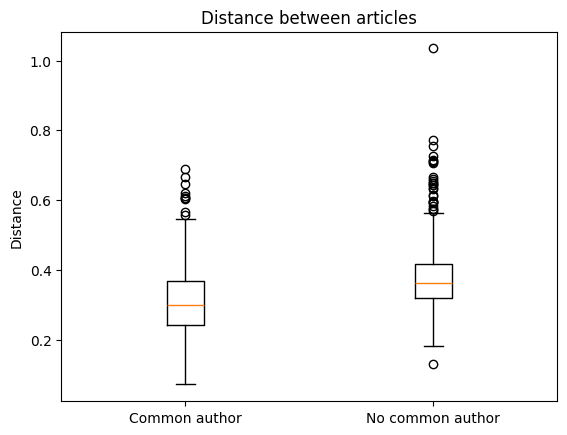

In [25]:
data = [common_author_distances, no_common_author_distances]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=['Common author', 'No common author'])
ax.set_ylabel("Distance")
plt.title(f"Distance between articles")
plt.show()

In [27]:
from scipy import stats

# Perform the t-test:
t_stat, p_value = stats.ttest_ind(common_author_distances, no_common_author_distances)
print(f"The mean distance between articles that share at least one author is {np.mean(common_author_distances):.2f}.")
print(f"The mean distance between articles that do not have a common author is {np.mean(no_common_author_distances):.2f}.")
print(f"The p-value is {p_value:.2E}.")


The mean distance between articles that share at least one author is 0.31.
The mean distance between articles that do nopt have a common author is 0.38.
The p-value is 1.44E-56.


Therefore, articles by the same authors are significantly closer to each other in topic space than articles by different authors, but the distances overlap.